In [11]:
!pip install germansentiment

In [12]:
!pip install deep-translator

In [719]:
!pip3 install pmdarima

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [794]:
import pandas as pd
import numpy as np
from germansentiment import SentimentModel
from deep_translator import GoogleTranslator
from time import perf_counter
import time
from functools import reduce
import operator
import collections
from collections import Counter
import datetime as dt
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [743]:
# Reading data
df = pd.read_csv("germany_tweets.csv", encoding= 'unicode_escape', index_col=0)
df.head()

text        date
1  AUSGETRICKSTE SCHWURBLER\nBitte lesen:\nhttps:...  2022-01-02
2  RT @shz_de: Zahlreiche #Crew-Mitglieder an Bor...  2022-01-02
3  RT @tagesschau: Liveblog: + Corona-Protest in ...  2022-01-02
4  RT @realTomBohn: Das #Omikron-#Coronavirus br...  2022-01-02
5  RT @realTomBohn: Das #Omikron-#Coronavirus br...  2022-01-02

In [747]:
# Extracting Month, Year and Week from date field
df['Date'] = pd.to_datetime(df['date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.strftime('%U')

In [745]:
#df.to_excel("validate_input_week_count.xlsx")

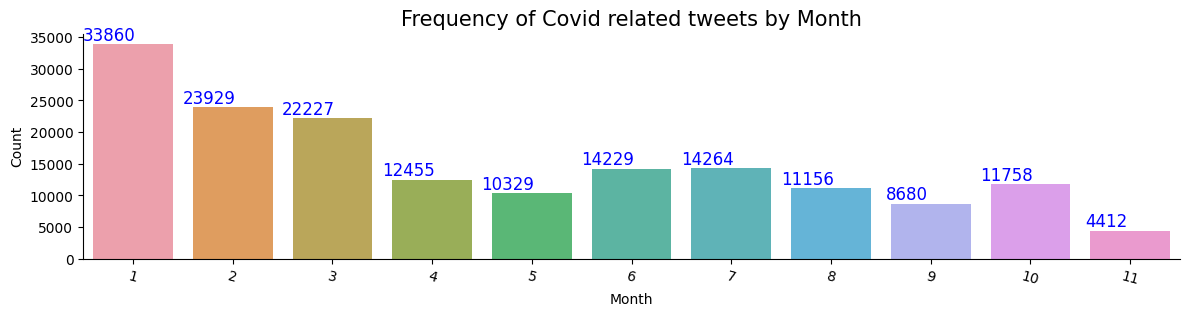

In [748]:
# Frequency of Covid related tweets by Month
# we have data for only 11 months ( from Jan 2022 till Nov 2022 )
tweets_by_month = df.groupby('Month').agg(Count=('text','count')).sort_values('Month', ascending=True)
sns.catplot(data=tweets_by_month.reset_index(), kind='bar', x='Month', y='Count',

alpha=0.9, height=3, aspect=4)
ax=plt.gca()

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(), '%d' % int(p.get_height()),fontsize=12, color ='blue', ha='center', va='bottom')

plt.title('Frequency of Covid related tweets by Month', fontsize=15, color='Black')
plt.tick_params(axis='x', rotation=-15, labelsize=10)
plt.show()

In [18]:
# Preprocessing steps

t0 = perf_counter()
print("Started preprocessing")

# 1. converting to lowercase
df['text'] = df['text'].str.lower()

#2. Lemmatizing : converting a word to its base form using Spacy
nlp = spacy.load("de_core_news_md")

token = []
pos_tag = []
noun_words = []
adjective_words = []
verb_words = []

for sent in nlp.pipe(df['text']):
    if sent.has_annotation('DEP'):
        token.append([word.text for word in sent])
        pos_tag.append([word.pos_ for word in sent])
        noun_words.append( [ word.text for word in sent if word.pos_ == 'NOUN' ] )
        adjective_words.append( [ word.text for word in sent if word.pos_ == 'ADJ' ] )
        verb_words.append( [ word.text for word in sent if word.pos_ == 'VERB' ] )



# 2. Tokenizing
df['tokenized_text'] = token

#3 Getting POS tags
df['pos_tag'] = pos_tag

print(df.head())

# 4. Counting the number of a specific pos tag in each row
df['noun_count'] = df.apply(lambda row: row['pos_tag'].count('NOUN'), axis=1)
df['verb_count'] = df.apply(lambda row: row['pos_tag'].count('VERB'), axis=1)
df['adj_count'] = df.apply(lambda row: row['pos_tag'].count('ADJ'), axis=1)


# 5. Separate out only Noun, Verb, Adverb and Adjective
df['noun_words'] = noun_words
df['adjective_words'] = adjective_words
df['verb_words'] = verb_words
#df['adverb_words'] = adverb_words

t1 = perf_counter()
time_taken = t1 - t0
print("Time taken to complete the pre-processing steps is : ", time_taken)

print(df.iloc[0])

Started preprocessing
                                                text        date       Date  \
1  ausgetrickste schwurbler\nbitte lesen:\nhttps:...  2022-01-02 2022-01-02   
2  rt @shz_de: zahlreiche #crew-mitglieder an bor...  2022-01-02 2022-01-02   
3  rt @tagesschau: liveblog: + corona-protest in ...  2022-01-02 2022-01-02   
4  rt @realtombohn: das #omikron-#coronavirus br...  2022-01-02 2022-01-02   
5  rt @realtombohn: das #omikron-#coronavirus br...  2022-01-02 2022-01-02   

   Month  Year Week                                     tokenized_text  \
1      1  2022   01  [ausgetrickste, schwurbler, \n, bitte, lesen, ...   
2      1  2022   01  [rt, @shz_de, :, zahlreiche, #, crew-mitgliede...   
3      1  2022   01  [rt, @tagesschau, :, liveblog, :, +, corona-pr...   
4      1  2022   01  [rt, @realtombohn, :, das, #, omikron-#corona...   
5      1  2022   01  [rt, @realtombohn, :, das, #, omikron-#corona...   

                                             pos_tag  
1  

In [588]:
df.shape

(167299, 6)

In [20]:
df[['noun_words', 'verb_words', 'adjective_words']].head()

noun_words         verb_words  \
1                                       [schwurbler]            [lesen]   
2  [#, crew-mitglieder, bord, kreuzfahrtschiffes,...        [infiziert]   
3                      [@tagesschau, corona-protest]        [aufgelöst]   
4                         [chance, #, immunisierung]  [breitet, wächst]   
5                         [chance, #, immunisierung]  [breitet, wächst]   

          adjective_words  
1  [ausgetrickste, biden]  
2            [zahlreiche]  
3                      []  
4               [baldige]  
5               [baldige]

In [21]:
df['noun_verb_adjective_combo'] = df['noun_words'].apply(list) + df['verb_words'].apply(list) +  df['adjective_words'].apply(list)
df['noun_verb_adjective_combo'].head()

1            [schwurbler, lesen, ausgetrickste, biden]
2    [#, crew-mitglieder, bord, kreuzfahrtschiffes,...
3             [@tagesschau, corona-protest, aufgelöst]
4    [chance, #, immunisierung, breitet, wächst, ba...
5    [chance, #, immunisierung, breitet, wächst, ba...
Name: noun_verb_adjective_combo, dtype: object

In [22]:
df

text        date  \
1       ausgetrickste schwurbler\nbitte lesen:\nhttps:...  2022-01-02   
2       rt @shz_de: zahlreiche #crew-mitglieder an bor...  2022-01-02   
3       rt @tagesschau: liveblog: + corona-protest in ...  2022-01-02   
4       rt @realtombohn: das #omikron-#coronavirus br...  2022-01-02   
5       rt @realtombohn: das #omikron-#coronavirus br...  2022-01-02   
...                                                   ...         ...   
167295  rt @traselvalle_obc: "desde iranzu (i)":\n\nht...  2022-11-13   
167296  rt @petbegdr: sonntag, der perfekte tag für de...  2022-11-13   
167297  rt @swraktuellbw: allein in #badenwürttemberg ...  2022-11-13   
167298  @corneliahuth ich frage mich seit 2020, was da...  2022-11-13   
167299  rt @jjaranaz94: "desde iranzu (i)":\n\nhttps:/...  2022-11-13   

             Date  Month  Year Week  \
1      2022-01-02      1  2022   01   
2      2022-01-02      1  2022   01   
3      2022-01-02      1  2022   01   
4      2022-01-02      1  2022   01   
5      2022-01-02      1  2022   01   
...           ...    ...   ...  ...   
167295 2022-11-13     11  2022   46   
167296 2022-11-13     11  2022   46   
167297 2022-11-13     11  2022   46   
167298 2022-11-13     11  2022   46   
167299 2022-11-13     11  2022   46   

                                           tokenized_text  \
1       [ausgetrickste, schwurbler, \n, bitte, lesen, ...   
2       [rt, @shz_de, :, zahlreiche, #, crew-mitgliede...   
3       [rt, @tagesschau, :, liveblog, :, +, corona-pr...   
4       [rt, @realtombohn, :, das, #, omikron-#corona...   
5       [rt, @realtombohn, :, das, #, omikron-#corona...   
...                                                   ...   
167295  [rt, @traselvalle_obc, :, ", desde, iranzu, (,...   
167296  [rt, @petbegdr, :, sonntag, ,, der, perfekte, ...   
167297  [rt, @swraktuellbw, :, allein, in, #, badenwür...   
167298  [@corneliahuth, ich, frage, mich, seit, 2020, ...   
167299  [rt, @jjaranaz94, :, ", desde, iranzu, (, i, )...   

                                                  pos_tag  noun_count  \
1       [ADJ, NOUN, SPACE, ADV, VERB, PUNCT, SPACE, PR...           1   
2       [X, PROPN, PUNCT, ADJ, NOUN, NOUN, ADP, NOUN, ...           5   
3       [X, NOUN, PUNCT, ADV, PUNCT, CCONJ, NOUN, ADP,...           2   
4       [X, PROPN, PUNCT, ADV, PROPN, X, VERB, PRON, A...           3   
5       [X, PROPN, PUNCT, ADV, PROPN, X, VERB, PRON, A...           3   
...                                                   ...         ...   
167295  [X, NOUN, PUNCT, PUNCT, ADP, PROPN, PUNCT, PRO...           1   
167296  [X, PROPN, PUNCT, ADV, PUNCT, DET, ADJ, NOUN, ...           8   
167297  [X, PROPN, PUNCT, ADV, ADP, PROPN, PROPN, VERB...           3   
167298  [PROPN, PRON, VERB, PRON, ADP, NUM, PUNCT, PRO...           6   
167299  [X, PROPN, PUNCT, PUNCT, ADP, PROPN, PUNCT, PR...           2   

        verb_count  adj_count  \
1                1          2   
2                1          1   
3                1          0   
4                2          1   
5                2          1   
...            ...        ...   
167295           0          0   
167296           0          3   
167297           1          1   
167298           3          0   
167299           0          0   

                                               noun_words  \
1                                            [schwurbler]   
2       [#, crew-mitglieder, bord, kreuzfahrtschiffes,...   
3                           [@tagesschau, corona-protest]   
4                              [chance, #, immunisierung]   
5                              [chance, #, immunisierung]   
...                                                   ...   
167295                                 [@traselvalle_obc]   
167296  [tag, #, impfung, #, impfstoff, uhr, helvetiap...   
167297                 [zahlen, menschen, sportmediziner]   
167298  [framing, menschen, rechtsradikalen, maßnahmen...   
167299          [https://t.co

In [23]:
# function to convert token to list and unpack
def get_term_freq(x):
    dlist = x.tolist()
    return (reduce(operator.add, dlist))

In [24]:
# function to count the term/word and create a dataframe for frequencies
def get_word_freq_per_month(x, y, word_freq_df):
    counter = Counter(x)
    most_occurrences = counter.most_common()
    count_df = pd.DataFrame(most_occurrences, columns = ['Word', 'Count'])
    count_df = count_df[count_df['Word'] != '#']
    count_df = count_df[count_df['Word'] != '%']
    count_df = count_df[~count_df.Word.str.startswith("@")]
    count_df = count_df[~count_df.Word.str.startswith("http")]
    count_df = count_df.iloc[0:10]
    count_df = count_df.reset_index(drop=True)
    word_freq_df_en = []
    for de_word in count_df['Word'].values:
        translated_word_en = GoogleTranslator(source='de', target='en').translate(de_word)
        word_freq_df_en.append(translated_word_en)
    count_df.loc[count_df.index , 'Word'] = word_freq_df_en
    count_df['Month'] = y
    count_df['Year'] = 2022
    print(count_df)
    #count_df.to_excel(f'Frequency{y}.xlsx')
    word_freq_df = word_freq_df.append(count_df, ignore_index=True)
    return word_freq_df

In [25]:
word_freq_df = pd.DataFrame(columns=['Word','Count','Month','Year'])
for i in range(1,12):
    word_by_month = df[(df['Year']==2022)&(df['Month']==i)]
    word_freq_df = get_word_freq_per_month(
        get_term_freq(word_by_month['noun_verb_adjective_combo']), 
        i, word_freq_df)

             Word  Count  Month  Year
0             new   4394      1  2022
1          deaths   3661      1  2022
2        reported   3336      1  2022
3           today   3218      1  2022
4   7 day average   3126      1  2022
5           white   2022      1  2022
6         protect   1670      1  2022
7          autumn   1635      1  2022
8         mutants   1623      1  2022
9  new infections   1388      1  2022
                 Word  Count  Month  Year
0                 new   2795      2  2022
1              deaths   2320      2  2022
2            reported   2015      2  2022
3               today   1949      2  2022
4              speaks   1944      2  2022
5          laboratory   1942      2  2022
6           developed   1917      2  2022
7            American   1912      2  2022
8              emails   1911      2  2022
9  chief immunologist   1910      2  2022
                      Word  Count  Month  Year
0                      new   1314      3  2022
1                incidence

In [26]:
word_freq_df.to_excel('Frequency_Of_Words.xlsx') # we can easily see all the frequent words in this output file

In [27]:
import plotly.graph_objects as go

fig = go.Figure()
for i in word_freq_df["Month"].unique():
    fig.add_trace(go.Bar(
        x = [word_freq_df.loc[word_freq_df["Month"]==i,"Month"],word_freq_df.loc[word_freq_df["Month"]==i,"Word"]],
        y = word_freq_df.loc[word_freq_df["Month"]==i,"Count"],
        name=str(i),
    ))
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.update_layout(barmode='group', width=2500, height=700)
fig.show()

In [52]:
# The below code for sentiment analysis should be run separately on a VM - takes very long time

import pandas as pd
import numpy as np
from germansentiment import SentimentModel
from time import perf_counter
import datetime as dt

df = pd.read_csv("germany_tweets.csv", encoding= 'unicode_escape', index_col=0)
print("Successfully read csv file")
df['Date'] = pd.to_datetime(df['date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.strftime('%U')
print("Added date related fields to the data frame")
t0 = perf_counter()
print("Started sentiment analysis, start time is : ", t0)
model = SentimentModel()
df['sentiment_analysis_result'] = None
df['Week'] = df['Week'].astype('int')
for i in range(1,47):
    print("processing sentiment analysis of week : ", i)
    weekly_text_data = df[df['Week'] == i]
    indexes_of_chosen_week = df[df['Week'] == i].index
    #print(type(weekly_text_data['text'].values.tolist()))
    result = model.predict_sentiment(weekly_text_data['text'].values.tolist())
    print("Got the result from german sentiment : ",result)
    result = np.array(result)
    result[result == 'neutral'] = 0
    result[result == 'positive'] = 1
    result[result == 'negative'] = -1
    result = result.astype(int)
    print("changed the result from germansentiment : ", result)
    df.loc[indexes_of_chosen_week , 'sentiment_analysis_result'] = result
    df.loc[indexes_of_chosen_week].to_excel(f"Sentiment_Analysis_Week_{i}.xlsx")
    print("processed sentiment analysis of week : ", i)
    
t1 = perf_counter()
time_taken = t1 - t0
print("Time taken to complete the sentiment analysis steps is : ", time_taken)
df.to_excel("full_german_covid_sentiment_analysis.xlsx")
    

In [589]:
# Reading sentiment analysis results into a dataframe
sentiment_analysis_df = pd.read_excel("full_german_covid_sentiment_analysis.xlsx", index_col=0)

negative_sentiments_result  Week
Week                                  
1                           1369     1
2                           1551     2
3                           1073     3
4                           1542     4
5                           1066     5
6                           1761     6
7                           1174     7
8                            691     8
9                            494     9
10                          1232    10
11                           980    11
12                           972    12
13                          1060    13
14                          1037    14
15                           868    15
16                           417    16
17                           329    17
18                           242    18
19                           310    19
20                           339    20
21                           620    21
22                           422    22
23                          1391    23
24                           676    24
25                          1139    25
26                          1287    26
27                           557    27
28                           502    28
29                          1062    29
30                           445    30
31                           244    31
32                           213    32
33                           220    33
34                           209    34
35                          1230    35
36                           582    36
37                           289    37
38                           523    38
39                           411    39
40                           282    40
41                           386    41
42                           659    42
43                           366    43
44                           356    44
45                          1055    45
46                            71    46

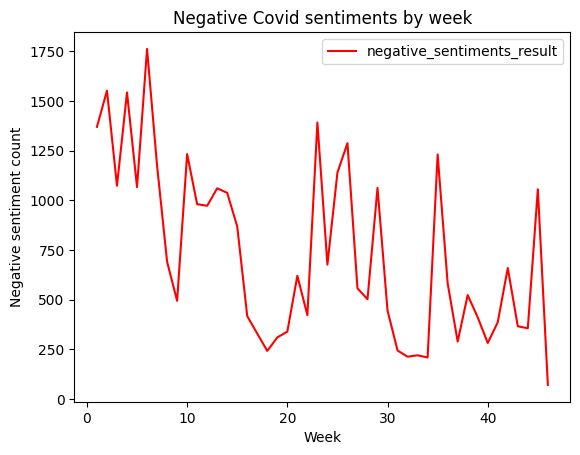

In [857]:
sentiment_analysis_df_negative = sentiment_analysis_df[sentiment_analysis_df['sentiment_analysis_result'] == -1]
df4 = sentiment_analysis_df_negative[['Week','sentiment_analysis_result']]
df4.rename(columns = {'sentiment_analysis_result': 'negative_sentiments_result'}, inplace = True)
df4 = df4.groupby(['Week']).count()
df4['Week'] = df4.index

display(df4)

# line plot for negative sentiments by week
ax = plt.gca()
df4.plot(kind='line', title='Negative Covid sentiments by week',
        x='Week',
        y='negative_sentiments_result',
        ylabel='Negative sentiment count',
        color='red', ax=ax)
plt.show()

positive_sentiments_result  Week
Week                                  
1                             39     1
2                             44     2
3                             52     3
4                             28     4
5                             26     5
6                             42     6
7                             63     7
8                             41     8
9                             16     9
10                           553    10
11                            43    11
12                            23    12
13                            83    13
14                            20    14
15                            31    15
16                            17    16
17                            18    17
18                            12    18
19                            16    19
20                            94    20
21                            15    21
22                            19    22
23                            32    23
24                            17    24
25                            26    25
26                            23    26
27                            15    27
28                            16    28
29                            15    29
30                            18    30
31                            28    31
32                            16    32
33                           141    33
34                            40    34
35                             6    35
36                             8    36
37                             2    37
38                            27    38
39                            15    39
40                            13    40
41                            47    41
42                            16    42
43                             9    43
44                            12    44
45                            10    45
46                             1    46

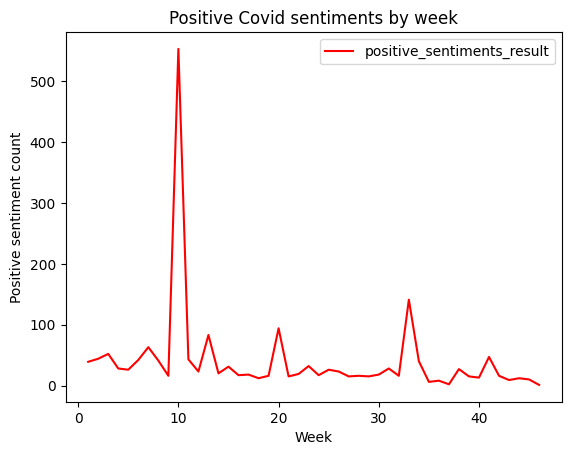

In [591]:
sentiment_analysis_df_positive = sentiment_analysis_df[sentiment_analysis_df['sentiment_analysis_result'] == 1]
df5 = sentiment_analysis_df_positive[['Week','sentiment_analysis_result']]
df5.rename(columns = {'sentiment_analysis_result': 'positive_sentiments_result'}, inplace = True)
df5 = df5.groupby(['Week']).count()
df5['Week'] = df5.index

display(df5)

# line plot for positive sentiments by week
ax = plt.gca()
df5.plot(kind='line',title='Positive Covid sentiments by week',
        x='Week',
        y='positive_sentiments_result',
        ylabel='Positive sentiment count',
        color='red', ax=ax)
plt.show()

avg_sentiment_analysis_result  Week
Week                                     
1                         -0.157695     1
2                         -0.207519     2
3                         -0.156403     3
4                         -0.150557     4
5                         -0.131081     5
6                         -0.241500     6
7                         -0.198570     7
8                         -0.160099     8
9                         -0.127979     9
10                        -0.125951    10
11                        -0.149228    11
12                        -0.187549    12
13                        -0.248917    13
14                        -0.280707    14
15                        -0.364071    15
16                        -0.122063    16
17                        -0.164116    17
18                        -0.142503    18
19                        -0.126234    19
20                        -0.132791    20
21                        -0.249897    21
22                        -0.112038    22
23                        -0.322726    23
24                        -0.182095    24
25                        -0.388211    25
26                        -0.348113    26
27                        -0.188391    27
28                        -0.143659    28
29                        -0.317369    29
30                        -0.164547    30
31                        -0.068922    31
32                        -0.089790    32
33                        -0.033531    33
34                        -0.109598    34
35                        -0.394203    35
36                        -0.329128    36
37                        -0.084486    37
38                        -0.265099    38
39                        -0.324059    39
40                        -0.174110    40
41                        -0.167325    41
42                        -0.198886    42
43                        -0.085653    43
44                        -0.221222    44
45                        -0.358368    45
46                        -0.131579    46

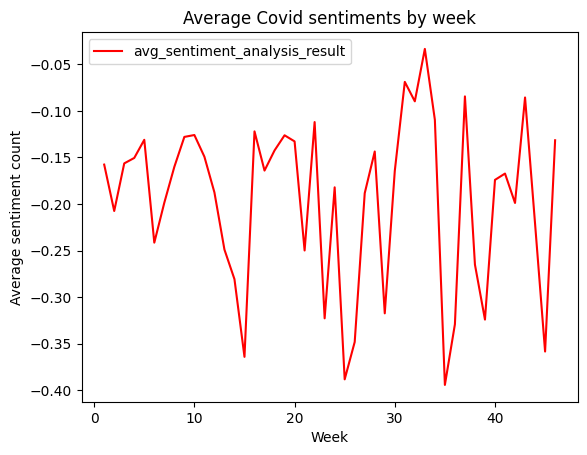

In [592]:
# Average covid sentiment analysis by week

df7 = sentiment_analysis_df[['Week','sentiment_analysis_result']]
df7 = df7.groupby(['Week']).agg(avg_sentiment_analysis_result=('sentiment_analysis_result', np.mean))
df7['Week'] = df7.index

display(df7)

# line plot for average sentiments by week
ax = plt.gca()
df7.plot(kind='line',title='Average Covid sentiments by week',
        x='Week',
        y='avg_sentiment_analysis_result',
        ylabel='Average sentiment count',
        color='red', ax=ax)
plt.show()

neutral_sentiments_result  Week
Week                                 
1                          7026     1
2                          5667     2
3                          5403     3
4                          8486     4
5                          6842     5
6                          5315     6
7                          4358     7
8                          3328     8
9                          3225     9
10                         3606    10
11                         5256    11
12                         4065    12
13                         2782    13
14                         2566    14
15                         1400    15
16                         2843    16
17                         1548    17
18                         1360    18
19                         2003    19
20                         1412    20
21                         1786    21
22                         3156    22
23                         2788    23
24                         2926    24
25                         1702    25
26                         2321    26
27                         2305    27
28                         2865    28
29                         2222    29
30                         2132    30
31                         2862    31
32                         1965    32
33                         1995    33
34                         1293    34
35                         1869    35
36                         1154    36
37                         3106    37
38                         1321    38
39                          796    39
40                         1250    40
41                         1593    41
42                         2558    42
43                         3793    43
44                         1187    44
45                         1851    45
46                          460    46

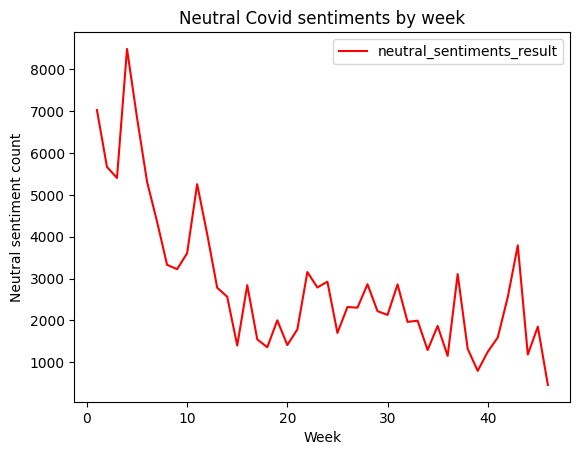

In [593]:
# Neutral covid sentiment analysis by week
sentiment_analysis_df_neutral = sentiment_analysis_df[sentiment_analysis_df['sentiment_analysis_result'] == 0]
df6 = sentiment_analysis_df_neutral[['Week','sentiment_analysis_result']]
df6.rename(columns = {'sentiment_analysis_result': 'neutral_sentiments_result'}, inplace = True)
df6 = df6.groupby(['Week']).count()
df6['Week'] = df6.index

display(df6)

# line plot for positive sentiments by week
ax = plt.gca()
df6.plot(kind='line',title='Neutral Covid sentiments by week',
        x='Week',
        y='neutral_sentiments_result',
        ylabel='Neutral sentiment count',
        color='red', ax=ax)
plt.show()

Week  new_cases       date
1       0      28965 2022-01-01
2       1      14225 2022-01-02
3       1      14579 2022-01-03
4       1      35950 2022-01-04
5       1      64490 2022-01-05
..    ...        ...        ...
361    52       4684 2022-12-27
362    52      46741 2022-12-28
363    52      39808 2022-12-29
364    52      29955 2022-12-30
365    52      22980 2022-12-31

[365 rows x 3 columns]

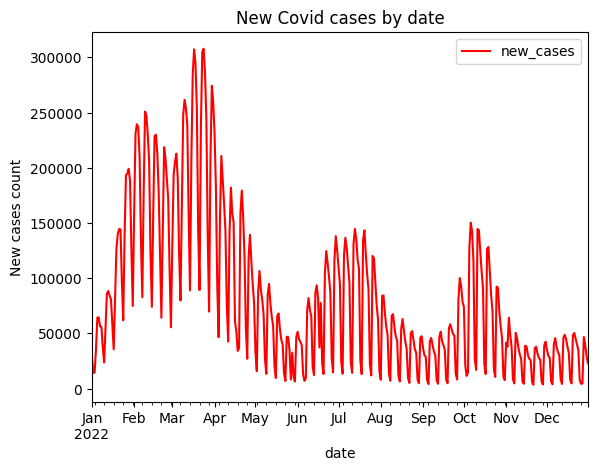

In [833]:
# ARIMA model starts here

# Reading Covid cases data - Day based approach

covid_cases_df = pd.read_csv("germany_cases.csv", encoding= 'unicode_escape', index_col=0)
df2 = covid_cases_df[['date','new_cases']]
df2['date'] = pd.to_datetime(df2['date'])
df2['Week'] = df2['date'].dt.strftime('%U').astype(int)

df8 = df2[['Week','new_cases', 'date']]
display(df8)

# line plot for new cases by days
ax = plt.gca()
df8.plot(kind='line', title='New Covid cases by date',
        x='date',
        y='new_cases',
        ylabel='New cases count',
        color='red', ax=ax)
plt.show()

In [834]:
def isSeriesStationary(series):
    pValue = adfuller(series)[1]
    print("pValue is : ", pValue)
    if pValue > 0.05:
        return False
    else:
        return True

In [835]:
if(not isSeriesStationary(df8["new_cases"])):
    print("As P-value is more than 0.05, Time Series is not stationary")
else:
    print("Time Series is stationary")

pValue is :  0.18865625587794466
As P-value is more than 0.05, Time Series is not stationary


In [836]:
def check_stationarity_via_graph(timeseries,name):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Time Series')
    mean = plt.plot(rolmean, color='red', label='Time Series Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Time Series Rolling Std deviation')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for {name} time series')
    plt.xlabel("Days")
    plt.ylabel("Value")
    plt.show(block=False)

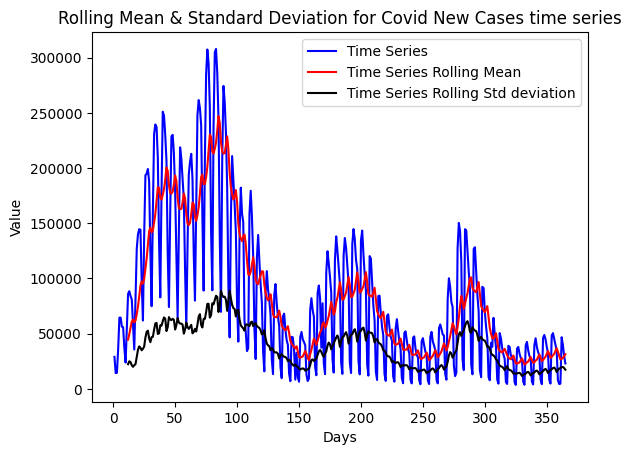

In [837]:
check_stationarity_via_graph(df8['new_cases'],'Covid New Cases')
# As we can see that mean and standard deviation of the timeseries is not constant, the data is not stationary

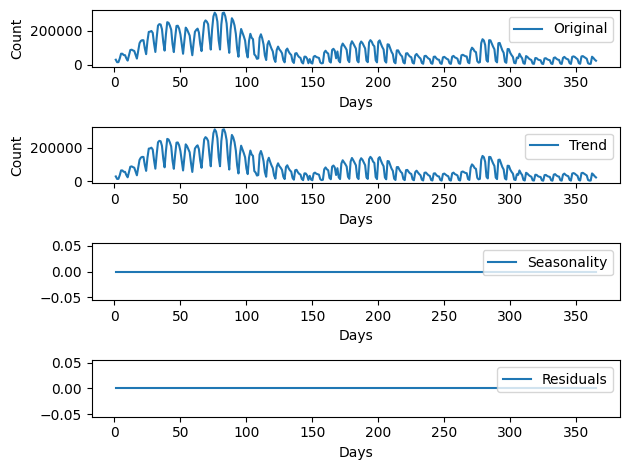

In [838]:
# Estimate trend and seasonlity
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(x=df8["new_cases"], period=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(df8["new_cases"], label='Original')
plt.legend(loc='best')
plt.xlabel("Days")
plt.ylabel("Count")

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xlabel("Days")
plt.ylabel("Count")

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.xlabel("Days")

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.xlabel("Days")
plt.tight_layout()

# Data has a downward trend and hence it is not stationary
# There is no seasonality in data and hence we can't use seasonal ARIMA

In [756]:
# Differencing is not needed as it is taken care automatically by auto arima

#df8['new_cases_first_difference'] = df8["new_cases"] - df8["new_cases"].shift(1)
#df8 = df8.dropna(inplace = False)
#display(df8)
#test_stationarity(df8['new_cases'],'Covid New Cases')
#display(df8)
#isSeriesStationary(df8)

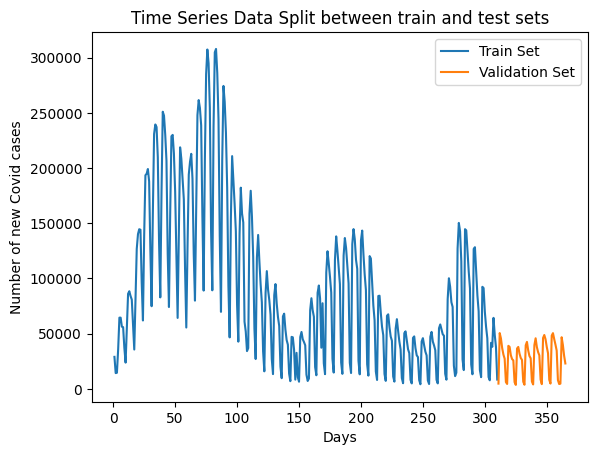

In [839]:
# Divide input data into train and validation sets
train = df8["new_cases"][:int(0.85*(len(df8["new_cases"])))]
valid = df8["new_cases"][int(0.85*(len(df8["new_cases"]))):]

# Plotting the data
plt.plot(train, label='Train Set')
plt.plot(valid, label='Validation Set')
plt.legend(loc='best')
plt.title("Time Series Data Split between train and test sets")
plt.xlabel("Days")
plt.ylabel("Number of new Covid cases")
plt.show()

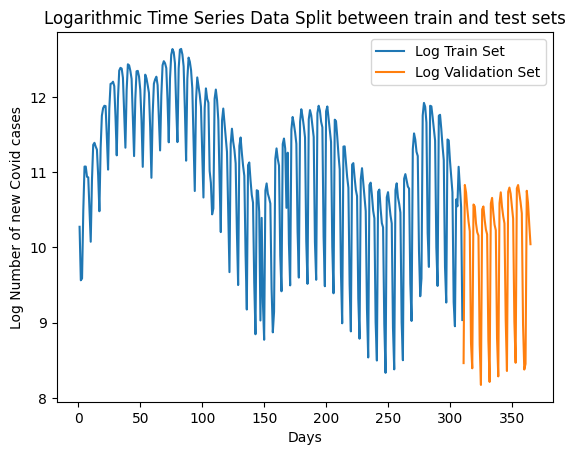

In [840]:
# Log transform the input data

#divide into train and validation set
train = np.log(df8["new_cases"][:int(0.85*(len(df8["new_cases"])))])
valid = np.log(df8["new_cases"][int(0.85*(len(df8["new_cases"]))):])
# display(np.exp(train))
# display(train)
#plotting the data
plt.plot(train, label='Log Train Set')
plt.plot(valid, label='Log Validation Set')
plt.legend(loc='best')
plt.title("Logarithmic Time Series Data Split between train and test sets")
plt.xlabel("Days")
plt.ylabel("Log Number of new Covid cases")
plt.show()

In [841]:
#building the model
def build_and_fir_arima_model(train):
    model = auto_arima(train,
                   method='nm',
                   trace=True, 
                   error_action='ignore',
                   seasonal=True,
                   suppress_warnings=True)

    model.fit(train)

    # print model summary
    print(model.summary())

    # Plot model diagnostics
    model.plot_diagnostics(figsize=(14,10))
    plt.show()
    return model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=779.290, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=771.810, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=773.783, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=773.688, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=769.817, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=706.849, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=653.236, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=726.891, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=719.687, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=777.650, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=724.414, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=781.062, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=654.230, Time=0.04 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 0.783 seconds
                               SARI

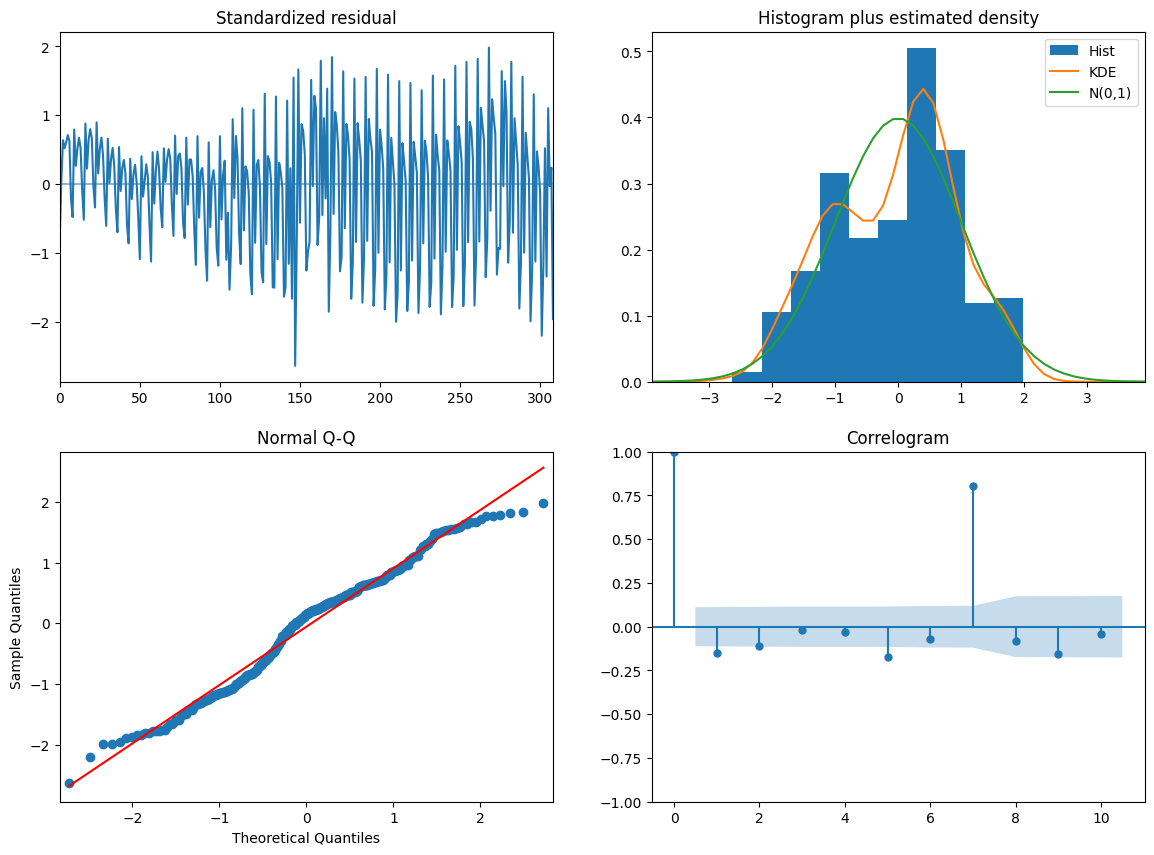

In [842]:
# Calling ARIMA model for daily case scenario
model = build_and_fir_arima_model(train)

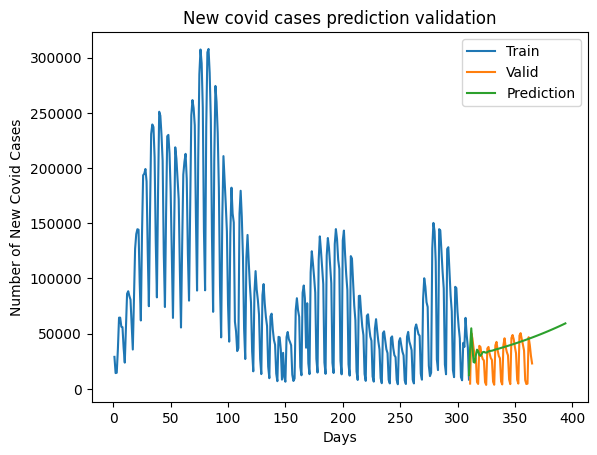

In [845]:
# Perform forecast and plot
forecast = model.predict(n_periods=len(valid)+30) # 30 days future prediction
forecast = pd.DataFrame(forecast,columns=['Prediction']) # index = valid.index

# Plot the predictions for validation set and even of future
plt.plot(np.exp(train), label='Train')
plt.plot(np.exp(valid), label='Valid')
plt.plot(np.exp(forecast), label='Prediction')
plt.legend(loc='best')
plt.xlabel("Days")
plt.ylabel("Number of New Covid Cases")
plt.title("New covid cases prediction validation")
plt.show()

In [846]:
# Check the number of actual Vs Predicted numbers
print("Predicted Number of new cases :")
display(np.exp(forecast))
print("Actual Number of new cases :")
display(df8.loc[valid.index]["new_cases"])

Predicted Number of new cases :


Prediction
310  12443.785834
311  36777.445697
312  54821.285843
313  37481.630394
314  24290.649733
..            ...
390  57321.103163
391  57804.270854
392  58291.511224
393  58782.858609
394  59278.347632

[85 rows x 1 columns]

Actual Number of new cases :


311     4732
312    50505
313    45693
314    36912
315    31040
316    27289
317     6136
318     4416
319    38957
320    37969
321    30398
322    26952
323    25779
324     6059
325     3541
326    36523
327    37953
328    31826
329    27968
330    26182
331     6444
332     3684
333    39441
334    42523
335    34835
336    29759
337    27687
338     6590
339     3967
340    39629
341    45781
342    37820
343    33276
344    30292
345     8426
346     4261
347    46068
348    48769
349    44953
350    37902
351    32278
352     8207
353     4752
354    48268
355    50452
356    45055
357    40121
358    34640
359     7868
360     4345
361     4684
362    46741
363    39808
364    29955
365    22980
Name: new_cases, dtype: int64

In [848]:
# Validate the Error of the model
mape = mean_absolute_percentage_error(np.exp(forecast["Prediction"].loc[valid.index]), np.exp(valid))
print("Mean Absolute percentage error ARIMA :", mape)

Mean Absolute percentage error ARIMA : 0.37173899424906653


In [849]:
# Week based Covid cases prediction 

# Reading covid cases data
df3 = df2.groupby(['Week']).sum()
df3['Week'] = df3.index
display(df3)

new_cases  Week
Week                 
0         28965     0
1        305889     1
2        453912     2
3        731410     3
4       1072905     4
5       1276191     5
6       1329621     6
7       1205836     7
8       1112732     8
9       1095907     9
10      1371125    10
11      1594967    11
12      1613360    12
13      1363468    13
14      1005452    14
15       811786    15
16       736190    16
17       628467    17
18       480991    18
19       419353    19
20       301531    20
21       190822    21
22       242301    22
23       319274    23
24       409319    24
25       568741    25
26       627160    26
27       628756    27
28       674816    28
29       631479    29
30       506216    30
31       366021    31
32       301241    32
33       266227    33
34       229777    34
35       202718    35
36       204258    36
37       227791    37
38       277636    38
39       448346    39
40       582844    40
41       653371    41
42       551475    42
43       383137    43
44       248813    44
45       204561    45
46       170607    46
47       170052    47
48       184373    48
49       197355    49
50       222657    50
51       231495    51
52       156381    52

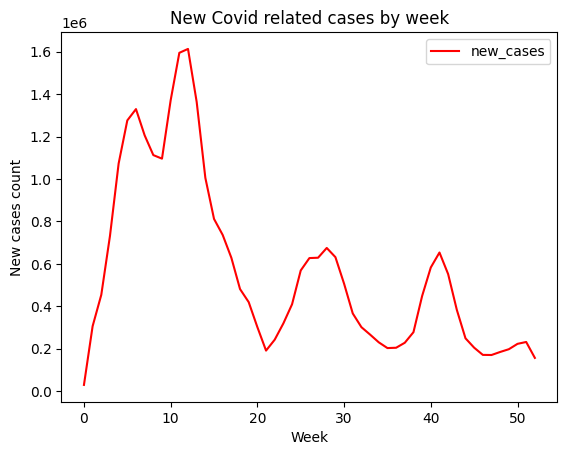

In [850]:
# Line plot for new cases by week
ax = plt.gca()
df3.plot(kind='line', title='New Covid related cases by week',
        x='Week',
        y='new_cases',
        ylabel='New cases count',
        color='red', ax=ax)
plt.show()

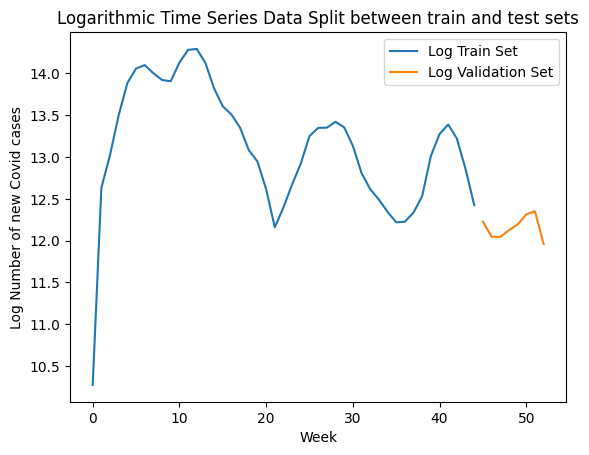

In [851]:
# Log transform and split the input data

# Divide into train and validation set
train = np.log(df3["new_cases"][:int(0.85*(len(df3["new_cases"])))])
valid = np.log(df3["new_cases"][int(0.85*(len(df3["new_cases"]))):])

# Plotting the data
plt.plot(train, label='Log Train Set')
plt.plot(valid, label='Log Validation Set')
plt.legend(loc='best')
plt.title("Logarithmic Time Series Data Split between train and test sets")
plt.xlabel("Week")
plt.ylabel("Log Number of new Covid cases")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=47.361, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=106.110, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59.991, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=72.966, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=361.594, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=51.655, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=44.839, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=49.614, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=43.899, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=44.921, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=50.542, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.345 seconds
                               SARIMAX Results                                
Dep. Variable:                    

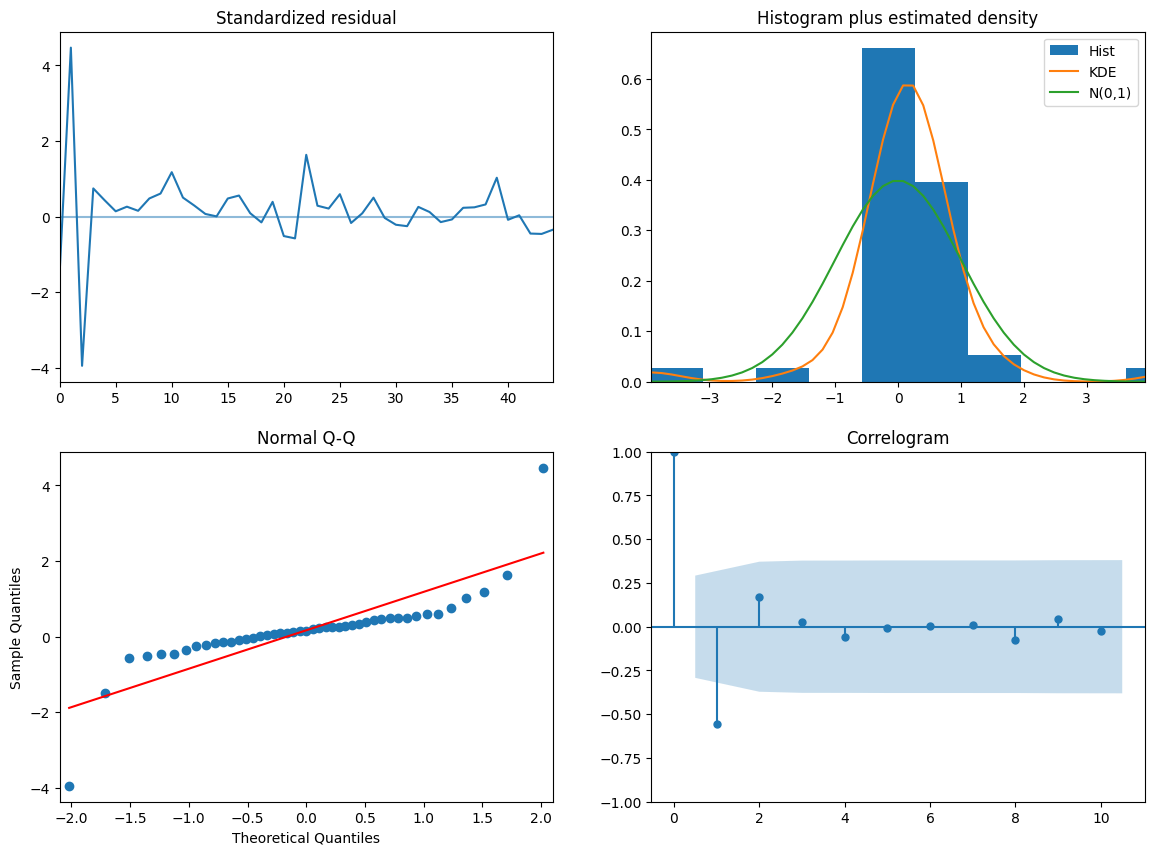

In [852]:
# Calling ARIMA model for weekly case scenario
model = build_and_fir_arima_model(train)

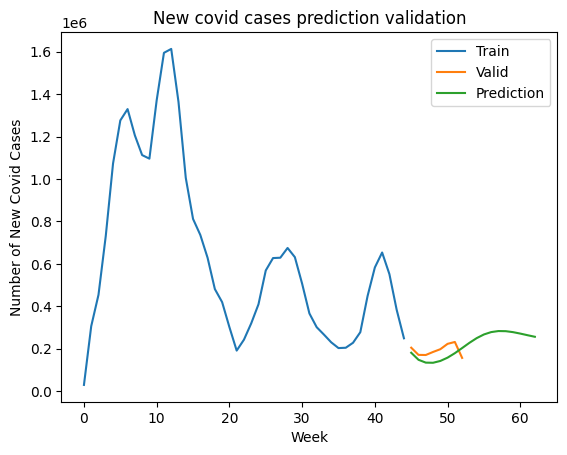

In [853]:
# Perform forecast and plot
forecast = model.predict(n_periods=len(valid)+10) # 10 weeks future prediction
forecast = pd.DataFrame(forecast,columns=['Prediction']) # index = valid.index

#plot the predictions for validation set
plt.plot(np.exp(train), label='Train')
plt.plot(np.exp(valid), label='Valid')
plt.plot(np.exp(forecast), label='Prediction')
plt.legend(loc='best')
plt.xlabel("Week")
plt.ylabel("Number of New Covid Cases")
plt.title("New covid cases prediction validation")
plt.show()

In [854]:
# Check the number of actual Vs Predicted numbers
print("Predicted Number of new cases :")
display(np.exp(forecast))
print("Actual Number of new cases :")
display(df3.loc[valid.index]["new_cases"])

Predicted Number of new cases :


Prediction
45  180691.820823
46  147482.742462
47  134110.600244
48  133431.253916
49  141952.667983
50  157627.928824
51  178643.750855
52  202798.978286
53  227392.820062
54  249573.316642
55  266949.053007
56  278139.167961
57  282988.548910
58  282387.020123
59  277839.125167
60  271002.066630
61  263346.397617
62  255985.820888

Actual Number of new cases :


Week
45    204561
46    170607
47    170052
48    184373
49    197355
50    222657
51    231495
52    156381
Name: new_cases, dtype: int64

In [855]:
# Validate the Error of the model
mape = mean_absolute_percentage_error(np.exp(forecast["Prediction"].loc[valid.index]), np.exp(valid))
print("Mean Absolute percentage error ARIMA :", mape)

Mean Absolute percentage error ARIMA : 0.2832802258953491


In [ ]:
df3.drop(columns=["Week"],inplace=True)
df4.drop(columns=["Week"],inplace=True)

In [971]:
# ARIMA model analysis with Weekly Covid Negative sentiments and Weekly New Cases
# Making the number of rows same in both d3(new cases data) and d4(negative sentiment data)  
df3 = df3.loc[df4.index]

# Concatenating two dataframes
df9 = pd.concat([df3, df4], axis=1)
print(df9)


      new_cases  negative_sentiments_result
Week                                       
1        305889                        1369
2        453912                        1551
3        731410                        1073
4       1072905                        1542
5       1276191                        1066
6       1329621                        1761
7       1205836                        1174
8       1112732                         691
9       1095907                         494
10      1371125                        1232
11      1594967                         980
12      1613360                         972
13      1363468                        1060
14      1005452                        1037
15       811786                         868
16       736190                         417
17       628467                         329
18       480991                         242
19       419353                         310
20       301531                         339
21       190822                 

In [935]:
def check_adf(series):
    print('Dickey-Fuller Test')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [967]:
check_adf(df9['new_cases'])

Dickey-Fuller Test
ADF test statistic      -1.241343
p-value                  0.655563
# lags used              2.000000
# observations          43.000000
critical value (1%)     -3.592504
critical value (5%)     -2.931550
critical value (10%)    -2.604066
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [937]:
check_adf(df9['negative_sentiments_result'])

Dickey-Fuller Test
ADF test statistic      -3.957199
p-value                  0.001652
# lags used              0.000000
# observations          45.000000
critical value (1%)     -3.584829
critical value (5%)     -2.928299
critical value (10%)    -2.602344
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [968]:
df9["new_cases_first_difference"] = df9["new_cases"] - df9["new_cases"].shift(1)
check_adf(df9["new_cases_first_difference"])
df9 = df9.drop(columns=["new_cases"])
df9=df9.dropna(axis=0)
#df9 = df9[df9.column > 0]
display(df9)

Dickey-Fuller Test
ADF test statistic      -4.402524
p-value                  0.000294
# lags used              9.000000
# observations          35.000000
critical value (1%)     -3.632743
critical value (5%)     -2.948510
critical value (10%)    -2.613017
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


negative_sentiments_result  new_cases_first_difference
Week                                                        
2                           1551                    148023.0
3                           1073                    277498.0
4                           1542                    341495.0
5                           1066                    203286.0
6                           1761                     53430.0
7                           1174                   -123785.0
8                            691                    -93104.0
9                            494                    -16825.0
10                          1232                    275218.0
11                           980                    223842.0
12                           972                     18393.0
13                          1060                   -249892.0
14                          1037                   -358016.0
15                           868                   -193666.0
16                           417                    -75596.0
17                           329                   -107723.0
18                           242                   -147476.0
19                           310                    -61638.0
20                           339                   -117822.0
21                           620                   -110709.0
22                           422                     51479.0
23                          1391                     76973.0
24                           676                     90045.0
25                          1139                    159422.0
26                          1287                     58419.0
27                           557                      1596.0
28                           502                     46060.0
29                          1062                    -43337.0
30                           445                   -125263.0
31                           244                   -140195.0
32                           213                    -64780.0
33                           220                    -35014.0
34                           209                    -36450.0
35                          1230                    -27059.0
36                           582                      1540.0
37                           289                     23533.0
38                           523                     49845.0
39                           411                    170710.0
40                           282                    134498.0
41                           386                     70527.0
42                           659                   -101896.0
43                           366                   -168338.0
44                           356                   -134324.0
45                          1055                    -44252.0
46                            71                    -33954.0

In [943]:
# Divide into train and validation set
train = df9[:int(0.85*(len(df9)))]
valid = df9[int(0.85*(len(df9))):]

In [947]:
# Grid Search
from statsmodels.tsa.api import VAR
min_aic = 999999999999999
min_order=10
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    if(results.aic<min_aic):
        min_aic=results.aic
        min_order = i
    print()
    
print("min_aic is : ", min_aic)
print("min_order is : ", min_order)

Order = 1
AIC:  35.00995722943544
BIC:  35.271187161215586

Order = 2
AIC:  34.706583662809564
BIC:  35.14645003460293

Order = 3
AIC:  34.836465338692655
BIC:  35.458604563288425

Order = 4
AIC:  35.043233061511664
BIC:  35.8513062804261

Order = 5
AIC:  35.04160967052171
BIC:  36.039281378166024

Order = 6
AIC:  35.245867616131804
BIC:  36.43677803715658

Order = 7
AIC:  35.45867020129417
BIC:  36.846399754021725

Order = 8
AIC:  35.58802856784402
BIC:  37.17605226706113

Order = 9
AIC:  34.31266886089858
BIC:  36.104297879501544

Order = 10
AIC:  34.36256258152648
BIC:  36.360869346789286

min_aic is :  34.31266886089858
min_order is :  9


In [948]:
# Fit VAR model based on min_order
result = model.fit(min_order)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Sep, 2023
Time:                     14:45:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    36.1043
Nobs:                     29.0000    HQIC:                   34.8738
Log likelihood:          -541.832    FPE:                1.33701e+15
AIC:                      34.3127    Det(Omega_mle):     4.88031e+14
--------------------------------------------------------------------
Results for equation negative_sentiments_result
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                               -29.777831       479.589964           -0.062           0.950
L1.negative_sentiments_result         0.174395         0.276969         

In [970]:
# Predict
lagged_Values = train.values[-9:]
pred = result.forecast(y=lagged_Values, steps=30) 
print(pred)

idx = pd.date_range('2022-01-01', periods=1, freq='MS')
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['negative_sentiments_result', 'new_cases_first_difference'])
print(df_forecast)


[[   638.09007744 232057.00572804]
 [   789.36043113 129032.33010272]
 [   637.94452319  25263.1537716 ]
 [   718.68125485 -43930.93592064]
 [   890.02078782  -1090.30301377]
 [   373.87488404  66658.87959676]
 [   352.81255462  72056.2923138 ]
 [   381.62437577  26503.65893739]
 [   283.19185834  14829.7779427 ]
 [   371.16184398   2775.55728861]
 [   425.45743221 -11183.29861321]
 [   375.89423292  13469.44084633]
 [   565.03083651  60488.59856014]
 [   600.11629657 116404.78183701]
 [   411.21506101 136254.17108031]
 [   521.32110584 119216.18015973]
 [   589.67738537 100202.72729298]
 [   566.92206388  98902.65525636]
 [   594.67421812  80674.25406639]
 [   547.25828239  55874.50782189]
 [   460.29709649  44996.47965513]
 [   481.92635836  50281.39023546]
 [   391.85688479  59616.67379047]
 [   295.28064649  54506.57433501]
 [   364.88197176  44305.42242937]
 [   401.39696759  50175.70974503]
 [   406.73383991  67604.30523939]
 [   445.49970832  78760.77468987]
 [   457.233191    9

ValueError: Shape of passed values is (30, 2), indices imply (1, 2)

In [ ]:
# Invert transformation
df_forecast['Money1d'] = (df['Money'].iloc[-test_obs-1]-df['Money'].iloc[-test_obs-2]) + df_forecast['money2d'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-test_obs-1] + df_forecast['Money1d'].cumsum()
df_forecast['Spending1d'] = (df['Spending'].iloc[-test_obs-1]-df['Spending'].iloc[-test_obs-2]) + df_forecast['Spending2d'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-test_obs-1] + df_forecast['Spending1d'].cumsum()

In [ ]:
# Plot
test_original = df[-test_obs:]
test_original.index = pd.to_datetime(test_original.index)
test_original['Money'].plot(figsize=(12,5),legend=True)
df_forecast['MoneyForecast'].plot(legend=True)

test_original['Spending'].plot(figsize=(12,5),legend=True)
df_forecast['SpendingForecast'].plot(legend=True)